# MNIST Handwritten Digits: Simple ANN Classifier

*This is pretty much just a re-write of my code from 2019 (except on the handwritten digits dataset and not the fashion dataset) - both because I was bored and to make it more readable + understandable.* 😄

The goal of this notebook is to create a simple artificial neural network classifier for the [MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/). All of this shall be achieved using only the [NumPy](https://numpy.org/) library, without the help of any modern machine-learning modules ([TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), ...).

In [1]:
import PIL
import gzip
import imageio
import numpy as np
import matplotlib.pyplot as plt
from typing import *

In [2]:
plt.ioff()

## Dataset Preparation

First of all, we need to create a couple of helper functions that will allows us to parse the datasets according to the format defined on their official [download page](http://yann.lecun.com/exdb/mnist/).

In [3]:
def read_features(fname: str, num: int, img_size: int = 28) -> np.matrix:
    """Read `num` images from the dataset and return them as an `np.matrix` of size (num, img_size * img_size)"""
    with gzip.open(fname) as f:
        f.read(16)
        data: np.ndarray = np.frombuffer(f.read(img_size * img_size * num), dtype=np.uint8).astype(np.float32)
        data = data.reshape(num, img_size * img_size)
    return np.asmatrix(data)

def read_labels(fname: str, num: int, label_size: int = 1) -> np.matrix:
    """Read `num` labels from the dataset and return them as an `np.matrix` of size (num, label_size)"""
    with gzip.open(fname) as f:
        f.read(8)
        labels: np.ndarray = np.frombuffer(f.read(num * label_size), dtype=np.uint8).astype(np.uint8)
        labels = labels.reshape(num, label_size)
    return np.asmatrix(labels)

Now, the training and test data + their labels can be loaded.

In [4]:
X_TRAIN: np.matrix  = read_features('data/train-images-idx3-ubyte.gz', 60_000)
Y_TRAIN: np.matrix  = read_labels('data/train-labels-idx1-ubyte.gz', 60_000)
X_TEST: np.matrix   = read_features('data/t10k-images-idx3-ubyte.gz', 10_000)
Y_TEST: np.matrix   = read_labels('data/t10k-labels-idx1-ubyte.gz', 10_000)

Still, we're not quite done yet. Looking at examples from the dataset, we can determine that the input images at the moement consist of `28x28` pixels, each with a value between `0` and `255`.

In [5]:
def plot_pixel_range(img: np.ndarray) -> None:
    """Plot the pixel value distribution + the image using matplotlib"""
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.violinplot(img.flatten())
    plt.title('Pixel value distribution')
    plt.xlabel('Probability density')
    plt.ylabel('Pixel value')
    plt.subplot(122)
    plt.imshow(img.reshape(28, -1), cmap='gray')
    plt.show()

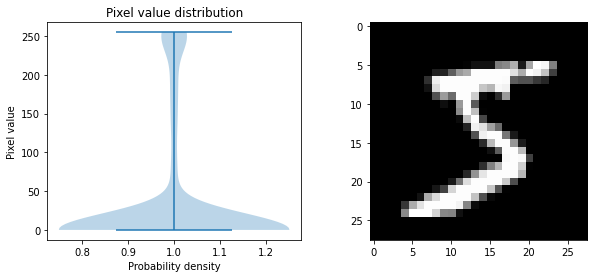

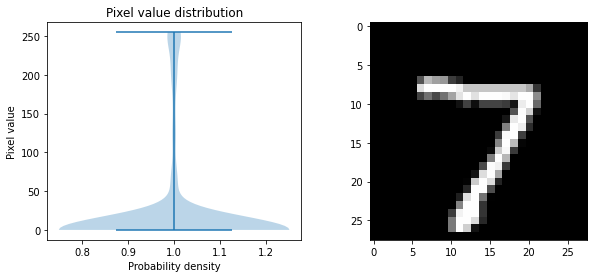

In [6]:
plot_pixel_range(np.asarray(X_TRAIN[0]))
plot_pixel_range(np.asarray(X_TEST[0]))

This is not optimal in terms of input for our neural network - explanations as to why not can be found on the Internet, e.g. ["Why Data should be Normalized before Training a Neural Network"](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d). Therefore, we should normalize them to the range of `[-1,1]`.

In [7]:
def normalize_features(x: np.matrix) -> np.matrix:
    """Normalizes the features to be fed into the neural network"""
    mu: np.ndarray = np.mean(x, axis=0)
    sigma: np.ndarray = np.max(x, axis=0) - np.min(x, axis=0)
    sigma[sigma < 1] = 1
    return (x - mu) / sigma

In [8]:
X_TRAIN = normalize_features(X_TRAIN)
X_TEST = normalize_features(X_TEST)

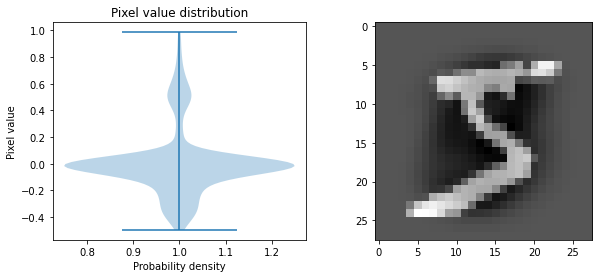

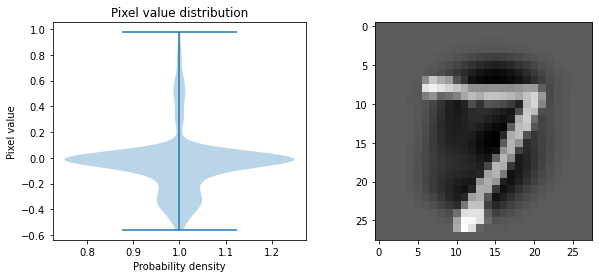

In [9]:
plot_pixel_range(np.asarray(X_TRAIN[0]))
plot_pixel_range(np.asarray(X_TEST[0]))

Tadaaa - looking better. Now we're ready to start building the network's components!

## Cost Function

Since this is a *multi-class classification problem*, we'll use the *categorical crossentropy loss* (CCE), which looks a little like the following:

$$
J(\hat{y}) = -\log{\hat{y}_p}
$$

... where `ŷ` represents the model's output/prediction (entire output layer's activiation) and `ŷ`<sub>p</sub> is the activiation of the output-layer neuron that represents the correct class - the class given by the ground truth / the labels. Since we are going to use *Mini-Batch Gradient Descent*, we're going to make a tiny altercation, however:

$$
J(\hat{y}) = -\frac{1}{M} \sum_{i=1}^{M} \log{\hat{y}_p^{\{i\}}}
$$

... where `M` is the batch size and `ŷ`<sub>p</sub><sup>{i}</sup> means the activiation of the output-layer neuron that represents the correct class of mini-batch entry `i`. Using this equation, we will be looking at the average loss across the mini-batch.

In [10]:
def loss(p: np.matrix, y: np.matrix, lam: float = 0, weights: List[np.matrix] = []) -> float:
    """Compute the (regularized) CCE for the given predictions + labels"""
    return (-1/y.shape[0]) * np.sum(np.log(np.take_along_axis(p.T, y, axis=1))) + (lam/(2 * y.shape[0])) * sum(np.sum(np.power(w, 2)) for w in weights)

### Output-Layer Activation Function

I've already mentioned that the problem we're trying to solve is a multi-class classification problem. Therefore, using the `softmax` activation function in the output layer seems like the best choice. Why? Well, once again you can read up on this [online](https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60), however, the short answer is: because it gives us a nice probability distribution for the possible classes as output.

In [11]:
def softmax(z: np.matrix) -> np.matrix:
    """Applies the softmax activation function to the given values"""
    return np.exp(z) / np.sum(np.exp(z), axis=0)

### Loss Derivation

Since we know, we are going to use the softmax function on the output layer **every time** - meaning also every time before computing the loss, we can just combine the gradient computation of these two as it works out rather neatly. ^^

$$
J(z^{[L-1]}) = -\frac{1}{M} \sum_{i=1}^{M} \log{\frac{ e^{z_p^{[L-1], \{i\}}} }{ \sum_{j=1}^{C} e^{z_j^{[L-1], \{i\}}} }}
$$

... where `L` is the number of layers in the network, the notation `z`<sup>[L-1]</sup> means the neurons at the last layer and `C` is the number of classes to choose from during prediction. With a little bit of calculus, we eventually arrive at the deriviations for both the *positive* and *negative* neurons - i.e. the neuron that should be `1` and the neurons that should be `0`.

$$
\frac{\partial}{\partial{z_p^{L[-1]}}}\left(J(z^{[L-1]})\right) = - \frac{ \sum_{j=1}^{C} e^{z_j^{[L-1]}} }{ e^{z_p^{[L-1}} } \frac{ e^{z_p^{[L-1]}} \left( \sum_{j=1}^{C} e^{z_j^{[L-1]}} \right) - \left(e^{z_p^{[L-1]}}\right)^2 }{ \left(\sum_{j=1}^{C} e^{z_j^{[L-1]}}\right)^2 } = \frac{ e^{z_p^{[L-1]}} }{ \sum_{j=1}^{C} e^{z_j^{[L-1]}} } - 1 = \hat{y}_p - 1
$$

$$
\frac{\partial}{\partial{z_n^{L[-1]}}}\left(J(z^{[L-1]})\right) = \frac{ \sum_{j=1}^{C} e^{z_j^{[L-1]}} }{ e^{z_p^{[L-1]}} } \frac{ e^{z_p^{[L-1]}} }{ \left( \sum_{j=1}^{C} e^{z_j^{[L-1]}} \right)^2 } e^{z_n^{[L-1]}} = \frac{ e^{z_n^{[L-1]}} }{ \sum_{j=1}^{C} e^{z_j^{[L-1]}} } = \hat{y}_n
$$

... where these are the deriviations per mini-batch entry - please forgive me for not writing `{i}` everywhere as well, as things appear messy enough as they are now ... ^^ Okay, now let's code what we just derived!

In [12]:
def loss_g(p: np.matrix, y: np.matrix) -> np.matrix:
    """Compute the neurons' gradients with regard to the loss (softmax has to be applied before loss computation)"""
    grad: np.matrix = softmax(p)
    np.put_along_axis(grad.T, y, np.take_along_axis(grad.T, y, axis=1) - 1, axis=1)     # subtract 1 from the "label" neurons
    return (1/y.shape[0]) * grad                                                        # return the gradients normalized by the batch size

## Activation Function(s)

Now that the loss is done, let's come to the next point: the activation functions. Actually, this sounds kind of misleading, because we're not going to use multiple activation functions at once. All hidden layers will use the same activation function, as it is usually the case. However, I thought I'd still include the `(logistic) sigmoid`, `TanH`  and `ReLU` functions nonetheless, to perhaps allow for a comparison between them as well.

In [13]:
def sigmoid(z: np.matrix) -> np.matrix:
    """Applies the logistic sigmoid function to the given values"""
    return 1 / (1 + np.exp(-z))

def tanh(z: np.matrix) -> np.matrix:
    """Applies the TanH activation function to the given values"""
    return np.tanh(z)

def relu(z: np.matrix) -> np.matrix:
    """Applies the ReLU activation function to the given values"""
    return z.clip(0)

Now, for a quick comparison - as always, more information can be found on the [Internet](https://www.kdnuggets.com/2017/09/neural-network-foundations-explained-activation-function.html) - let's just run some values through the activation functions to get a nice general understanding of what these activation functions do:

In [18]:
def plot_actf(f: Union[Callable[[np.matrix], np.matrix], List[Callable[[np.matrix], np.matrix]]], low: int = -10, high: int = 10, n: int = 200):
    """Run some values through some activation functions and plot the result"""
    plt.figure(figsize=(10,4))
    if type(f) != list:
        f = [f,]
    for i, x in enumerate(f):
        plt.subplot(1, len(f), i+1)
        plt.title(x.__name__)
        plt.plot(np.linspace(low, high, n), np.asarray(x(np.asmatrix(np.linspace(low, high, n)))).flatten())
    plt.show()

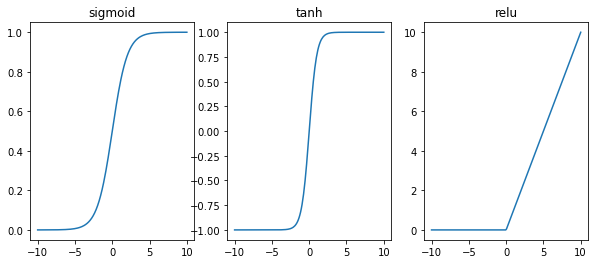

In [20]:
plot_actf([sigmoid, tanh, relu,])

As you can see, the main differences are:

* *Sigmoid* ... maps all values in the range `[0,1]`
* *TanH* ... maps all values in the range `[-1,1]`
* *ReLU* ... maps all values in the range `[0,inf]`

Once again, I'd recommend further research to learn more about the differences between these activation functions and when to use which one. But perhaps, we'll make some discoveries in the rest of this notebook as well.

### Activation Functions Derivations

Of course, to train our network, we also need the derivations of our activation functions. So, let's get to that next. In the case of the `sigmoid` function, the derivative should look something like:

$$
\sigma'(z) = \frac{\partial}{\partial{z}}\left( \frac{1}{1 + e^{-z}} \right) = \frac{e^{-z}}{ \left( 1 + e^{-z} \right)^2 } = \frac{1}{1 + e^{-z}} \frac{e^{-z} + 1 - 1}{1 + e^{-z}} = \frac{1}{1 + e^{-z}} \left( 1 - \frac{1}{1 + e^{-z}} \right) = \sigma(z) \left( 1 - \sigma(z) \right)
$$

... the derivative of the `TanH` can be derived like so:

$$
tanh'(z) = \frac{\partial}{\partial{z}}\left( \frac{e^z - e^{-z}}{e^z + e^{-z}} \right) = \frac{ \left( e^z + e^{-z} \right)^2 - \left( e^z - e^{-z} \right)^2 }{ \left( e^z + e^{-z} \right)^2 } = 1 - tanh^2(z)
$$

... and the `ReLU` derivative is a bit simpler + should look like:

$$
relu'(z) = \frac{\partial}{\partial{z}}\left( 
    \left\{ 
        \begin{array}{ c l }
            z   & \quad \textrm{if } z \gt 0 \\
            0   & \quad \textrm{otherwise}
        \end{array}
    \right. 
\right) = \left\{ 
    \begin{array}{ c l }
        1   & \quad \textrm{if } z \gt 0 \\
        0   & \quad \textrm{otherwise}
    \end{array}
\right. 
$$

In [21]:
def sigmoid_g(z: np.matrix) -> np.matrix:
    """Computes the gradients of the sigmoid function"""
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

def tanh_g(z: np.matrix) -> np.matrix:
    """Computes the gradients of the TanH function"""
    return 1 - np.power(tanh(z), 2)

def relu_g(z: np.matrix) -> np.matrix:
    """Computes the gradients of the ReLU function"""
    r: np.matrix = np.zeros(z.shape)
    r[z>0] = 1
    return r

## Training Functions

Now it's finally time to lay the groundwork for the learning process - it's time to come up with our `training` function. Our training function will train the network's weights over several epochs based on the loss it generates during the labelling of mini-batches of the dataset (= *mini-batch SGD*). Since, like I already mentioned, training is essentially doing *forward propagation* and subsequently *backpropagation* over and over again, over the course of multiple *epochs* - we should define the computation of gradients during an epoch as its own function - `step`: 

In [22]:
def step(x: np.matrix, y: np.matrix, weights: List[np.matrix], actf: List[Callable[[np.matrix], np.matrix]],
         actf_g: List[Callable[[np.matrix], np.matrix]], lam: float = .03) -> List[np.matrix]:
    """
    Take a single training step - i.e. complete a training epoch and return the computed gradients
    :param x: A mini-batch of features
    :param y: The labels for the mini-batch
    :param weights: The weights of the network
    :param actf: The activiation functions of the networks' layers
    :param actf_g: The derivations of the activation functions
    :param lam: The regularization parameter lambda - for weight regularization
    :return: The weights' computed gradients
    """

    assert actf[-1] == softmax          # last activation function has to be softmax
    assert len(weights) == len(actf)    # every layer has to have an activation function
    assert len(actf) == len(actf_g) + 1 # every activation fun. must have a derivation (except last, since part of loss derivative)
    assert x.shape[1] == y.shape[0]     # every batch entry has to have a label

    l_val: List[np.matrix] = [ x, ]     # the raw values of a network layer
    l_act: List[np.matrix] = [ x, ]     # the activations of a network layer

    # FORWARD PROPAGATION

    for w, a in zip(weights, actf):
        l_val.append(w.T * np.vstack(( l_act[-1], np.ones(l_act[-1].shape[1]) )))       # add all ones to act as bias nodes
        l_act.append(a(l_val[-1]))                                                      # pass values through activation function
    
    # BACKPROPAGATION

    l_grad: List[np.matrix] = [ loss_g(l_val[-1], y), ]
    w_grad: List[np.matrix] = []

    for i, (w, d) in enumerate(reversed(list(zip(weights, [ *actf_g, lambda x: np.ones(x.shape), ]))), 1):
        delta: np.matrix = np.multiply(l_grad[-1], d(l_val[-i]))
        w_grad.append(np.vstack(( l_val[-i-1], np.ones(l_val[-i-1].shape[1]) )) * delta.T + (lam/y.shape[0]) * w)
        l_grad.append(w[:-1,:] * delta)

    return list(reversed(w_grad))

Both since we want to take a look at how our model's loss changes during training and because we surely want to make predictions based on features later on, we should also come up with a function that only does the *forward propagation* stuff we already used in the `step` function.

In [23]:
def predict(x: np.matrix, weights: List[np.matrix], actf: List[Callable[[np.matrix], np.matrix]]) -> np.matrix:
    """
    Predict the classes for the given input - i.e. run the input through the network
    :param x: The input features
    :param weights: The weights of the network
    :param actf: The activiation functions of the networks' layers
    :return: The network's output - i.e. its prediction
    """
    activation: np.matrix = x
    for w, a in zip(weights, actf):
        activation = a(w.T * np.vstack(( activation, np.ones(activation.shape[1]) )))
    return activation

And since our model's output layer won't produce just a single number to represent its prediction, but rather outputs a probabilty distribution accross 10 classes, we should also create a helper function that discovers the class with the highest probability:

In [24]:
def make_class(p: np.matrix) -> np.matrix:
    """Turns the raw output of the network into actual class numbers"""
    return np.argmax(p, axis=0)

And finally, the `train` function that calls `step` every epoch and uses the *optimizer* it has been given to adjust the network's weights according to the gradients that were computed on its loss.

In [25]:
def train(x: np.matrix, y: np.matrix, weights: List[np.matrix], actf: List[Callable[[np.matrix], np.matrix]],
          actf_g: List[Callable[[np.matrix], np.matrix]], optimizer: Callable[..., np.matrix], epochs: int, 
          optimizer_args: List[Any] = [], optimizer_kwargs: Dict[str, Any] = {}, batch_size: int = 32, 
          lam: float = .03) -> List[np.matrix]:
    """
    Perform Mini-Batch Gradient Descent on the given dataset using the given weights & parameters
    :param x: The feature part of the dataset
    :param y: The labels of the dataset
    :param weights: The weights of the network
    :param actf: The activiation functions of the networks' layers
    :param actf_g: The derivations of the activation functions
    :param optimizer: The optimizer to use for weight adjustion
    :param epochs: The number of epochs to train for
    :param optimizer_args: The positional arguments for the optimizer function
    :param optimizer_kwargs: The keyword arguments for the optimizer function
    :param batch_size: The batch-size to use for mini-batch gradient descent
    :param lam: The regularization parameter lambda - for weight regularization
    :return: The newly trained weights
    """
    weights = [ w.copy() for w in weights ]
    for i in range(epochs):
        if i%(epochs//10) == 0:
            print(f'[{i:04d}/{epochs:04d}] Loss = {loss(predict(X_TEST.T, weights, actf), Y_TEST)} ... ')
        choices: np.ndarray = np.random.choice(np.arange(x.shape[0]), batch_size)
        grad: List[np.matrix] = step(x[choices].T, y[choices], weights, actf, actf_g, lam)
        for j in range(len(weights)):
            weights[j] = optimizer(weights[j], grad[j], j, *optimizer_args, **optimizer_kwargs)
    return weights

### Optimizers

Another one of the key parts in training a neural network is how the weights are updated with knowledge of their respective gradients - what *optimizer* is being used. I therefore decided to include not just one, but multiple optimizers - ranging from the vanilla *SGD (stochastic gradient descent)* optimizer over *SGD with momentum* ([more info](https://paperswithcode.com/method/sgd-with-momentum)) to the probably most popular optimizer *Adam* ([more info](https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218)).

In [26]:
def vanilla(weight: np.matrix, grad: np.matrix, i: int, alpha: float) -> np.matrix:
    """
    Given a weight matrix and its gradient, perform vanilla gradient descent
    :param weight: The weight matrix connecting two layers in a neural net
    :param grad: The corresponding gradients
    :param i: The index of the weights that are being updated
    :param alpha: The learning rate "alpha"
    :return: The new weight matrix
    """
    return weight - alpha * grad

def make_momentum(neurons: List[int], gamma: float) -> Callable[[np.matrix, np.matrix, float], np.matrix]:
    """
    Wrapper function to create a new gradient descent w. momentum optimizer
    :param neurons: The number of neurons at each layer - the network's shape
    :param gamma: The hyperparameter for momentum decay
    :return: An instance of a momentum optimizer
    """
    v: List[np.matrix] = [ np.zeros((neurons[i]+1, neurons[i+1])) for i in range(len(neurons)-1) ]

    def momentum(weight: np.matrix, grad: np.matrix, i: int, alpha: float) -> np.matrix:
        """
        Given a weight matrix and its gradient, perform gradient descent w. momentum
        :param weight: The weight matrix connecting two layers in a neural net
        :param grad: The corresponding gradients
        :param i: The index of the weights that are being updated
        :param alpha: The learning rate "alpha"
        :return: The new weight matrix
        """ 
        v[i] = gamma * v[i] + alpha * grad
        return weight - v[i]
    
    return momentum

def make_adam(neurons: List[int], beta1: float, beta2: float, epsilon: float = 1e-7) -> Callable[[np.matrix, np.matrix, float], np.matrix]:
    """
    Wrapper function to create a new Adam optimizer
    :param neurons: The number of neurons at each layer - the network's shape
    :param beta1: The hyperparameter for first order moment decay
    :param beta2: The hyperparameter for second order moment decay
    :param epsilon: A hyperparameter to prevent divisions by zero
    :return: An instance of an Adam optimizer
    """
    m: List[np.matrix] = [ np.zeros((neurons[i]+1, neurons[i+1])) for i in range(len(neurons)-1) ]
    v: List[np.matrix] = [ np.zeros((neurons[i]+1, neurons[i+1])) for i in range(len(neurons)-1) ]

    def adam(weight: np.matrix, grad: np.matrix, i: int, alpha: float) -> np.matrix:
        """
        Given a weight matrix and its gradient, perform gradient descent w. AdaDelta
        :param weight: The weight matrix connecting two layers in a neural net
        :param grad: The corresponding gradients
        :param i: The index of the weights that are being updated
        :param alpha: The learning rate "alpha"
        :return: The new weight matrix
        """
        m[i] = beta1 * m[i] + (1 - beta1) * grad
        v[i] = beta2 * v[i] + (1 - beta2) * np.power(grad, 2)
        m_s: np.matrix = m[i] / (1 - beta1)
        v_s: np.matrix = v[i] / (1 - beta2)
        return weight - alpha * np.multiply(m_s, 1 / np.sqrt(v_s + epsilon))

    return adam

## Network Definition

Now - having prepared the dataset, having coded several activation functions and their derivations, plus having finished the actual *Mini-Batch SGD* training function and several optimizers - it's finally time to start defining our actual *neural network*! 

Kind of anticlimactic, but actually all we really need to do in order to define our network is to create a list of *weight* matrices. This is probably where many self-coded implementations of neural nets differ, because some might choose to define their own *bias* vectors as well - I remember having done it like this once as well - however, we're not going to do this. Why? Well, because we choose the - might I say - rather *cool* approach (^^) of just including the bias in our weights matrices and simply adding fully activated nodes (all 1s) to a layer's activation during *forward propagation*. 

This probably wasn't a very clear explanation - but don't worry, the code of the `train` and `predict` functions is hopefully clear and well-documented enough for you to understand what I just tried to explain on your own ^^.

Actually, I kind of lied about the creation of weights being the only thing we needed to do, of course we also need to initialize those weights properly! I hope I don't forget to experiment & therefore demonstrate why this is a **rather important** step during neural network creation. Anyway, there are several ways to do this - some work better than others for certain tasks - so I implemented a few. To be precise, I've implemented some sort of *"vanilla" weight initialization* (= random, uniformly distributed values), *standard weight initialization* (= uniformly random values normalized by the number of input neurons), *xavier init* (= more sophisticated normalization) and *he init* (= also more sophisticated normalization; designed to work well with *ReLU*s). You can read up on all these in [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79) rather cool Medium article.

In [27]:
def uniform_init(neurons: List[int]) -> List[np.matrix]:
    """
    Generates initalized weights for a network of the given size
    :param neurons: The number of neurons in each layer
    :return: The uniformly randomly initalized weights of the network
    """
    return [ np.asmatrix(np.random.uniform(-1, 1, (neurons[i]+1, neurons[i+1]))) for i in range(len(neurons)-1) ]

def standard_init(neurons: List[int]) -> List[np.matrix]:
    """
    Generates initalized weights for a network of the given size
    :param neurons: The number of neurons in each layer
    :return: The "Standard"-initalized weights of the network
    """
    return [ np.asmatrix(np.random.uniform(-1, 1, (neurons[i]+1, neurons[i+1])) * np.sqrt(1 / (neurons[i]+1))) for i in range(len(neurons)-1) ]

def xavier_init(neurons: List[int]) -> List[np.matrix]:
    """
    Generates initalized weights for a network of the given size
    :param neurons: The number of neurons in each layer
    :return: The "Xavier"-initalized weights of the network
    """
    return [ np.asmatrix(np.random.uniform(-1, 1, (neurons[i]+1, neurons[i+1])) * np.sqrt(6 / (neurons[i]+1 + neurons[i+1]))) for i in range(len(neurons)-1) ]

def he_init(neurons: List[int]) -> List[np.matrix]:
    """
    Generates initialized weights for a network of the given size
    :param neurons: The number of neurons in each layer
    :return: The "He"-initalized weights of the network
    """
    return [ np.asmatrix(np.vstack(( np.random.uniform(-1, 1, (neurons[i], neurons[i+1])) * np.sqrt(2 / neurons[i]), np.zeros((1, neurons[i+1])) ))) for i in range(len(neurons)-1) ]

In [28]:
neurons: List[int] = [ 28*28, 200, 10, ]        # specifies the number of neurons at each layer
weights: List[np.matrix] = he_init(neurons)     # creates + initializes the weights
actf: List[Callable[[np.matrix], np.matrix]] = [ relu, ] * (len(weights) - 1) + [ softmax, ]        # the activation functions
actf_g: List[Callable[[np.matrix], np.matrix]] = [ relu_g, ] * (len(weights) - 1)                   # their derivations

## Training

Before we start training our network (aka the list of weights we just created) we have to decide on the value of some hyperparameters that the training process is going to make use of. Bear in mind that the value of these parameters is generally not *fixed*, but can be adjusted to your heart's desire until the training process yields the best model. However, don't disregard that these parameters generally tend to be rather sensitive - for most hyperparameters (apart from batch-size and epochs, duh ^^) altercations in the scale of hundredths can influence the outcome vastly.

In [29]:
ALPHA: float        = .005      # the learning rate, α
LAMBDA: float       = .03       # the regularization parameter to prevent weights from exploding, λ
GAMMA: float        = .9        # a decay parameter for optimizers, γ
BETA1: float        = .9        # a decay parameter for Adam, β_1
BETA2: float        = .999      # a decay parameter for Adam, β_2
EPSILON: float      = 1e-7      # a parameter to prevent divison by zero in multiple optimizers, ε
BATCH_SIZE: int     = 64        # the batch size for multi-batch SGD
EPOCHS: int         = 1024      # the number of epochs (= iterations) to train for

In [30]:
n_weights: List[np.matrix] = train(X_TRAIN, Y_TRAIN, weights, actf, actf_g, make_adam(neurons, BETA1, BETA2, EPSILON), EPOCHS, 
                                   optimizer_args=[ALPHA,], batch_size=BATCH_SIZE, lam=LAMBDA)

[0000/1024] Loss = 2.289437634567448 ... 
[0102/1024] Loss = 0.2510138335177287 ... 
[0204/1024] Loss = 0.20520624435572477 ... 
[0306/1024] Loss = 0.1908445591584997 ... 
[0408/1024] Loss = 0.1721428853494841 ... 
[0510/1024] Loss = 0.17509367051729202 ... 
[0612/1024] Loss = 0.1541302101196133 ... 
[0714/1024] Loss = 0.14831913399884608 ... 
[0816/1024] Loss = 0.152860591749524 ... 
[0918/1024] Loss = 0.1495299631176866 ... 
[1020/1024] Loss = 0.14330272413873094 ... 


## Evaluation

Cool! We have trained a neural network to recognize handwritten digits - but... I personally am not satisfied with just watching the *loss* going down during the training process! I want to see what it can do as well - don't you too?

First of all, let's discard the *loss* function for a moment and come up with another, perhaps more easily understandable metric to measure our network's perfomance. How about *accuracy*? We take some predictions our model made and their actual labels and see what percentage our model managed to predict correctly!

In [31]:
def accuracy(p: np.matrix, y: np.matrix) -> float:
    """Calculates the accuracy of the given predictions [%]"""
    assert p.shape == y.shape
    return 1 - (np.count_nonzero(p - y) / y.shape[0])

In [32]:
print(f'[*] Accuracy (training): {accuracy(make_class(predict(X_TRAIN.T, n_weights, actf)).T, Y_TRAIN)*100:.3f}% ... ')
print(f'[*] Accuracy (testing): {accuracy(make_class(predict(X_TEST.T, n_weights, actf)).T, Y_TEST)*100:.3f}% ... ')

[*] Accuracy (training): 96.435% ... 
[*] Accuracy (testing): 96.130% ... 


However, it would also be cool to really *see* the model's predictions. How about we pick some random data from the test dataset, visualize it and colour it either in a *red-ish* or *green-ish* manner, depending on whether or not our model predicted the digit correctly! (*green* being a correct prediction, if my choice of colours isn't intuitive enough ^^).

In [33]:
def plot_pred(x: np.matrix, y: np.matrix, weights: List[np.matrix], actf: List[Callable[[np.matrix], np.matrix]], 
              size: Tuple[int, int], labels: bool = True, fname: Optional[str] = None) -> None:
    """Plot some predictions using the given network, features and labels"""
    plt.figure(figsize=(10, 5))
    for i in range(size[0]):
        for j in range(size[1]):
            plt.subplot(*size, i*size[1]+j+1)
            choice: int = np.random.randint(0, x.shape[0])
            r: np.matrix = x[choice]
            p: int = np.asarray(make_class(predict(r.T, weights, actf))).flatten()[0]
            l: int = np.asarray(y)[choice][0]
            plt.imshow(r.reshape(28, 28), cmap='summer' if p == l else 'spring')
            if labels:
                plt.title(f'{p} (actually {l})')
            else:
                plt.axis('off')
    if fname:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()

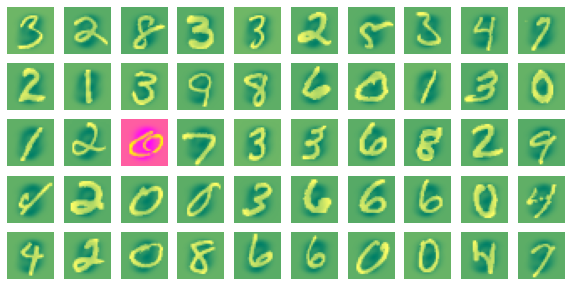

In [34]:
plot_pred(X_TEST, Y_TEST, n_weights, actf, (5, 10), labels=False)

Wouldn't it be cool to have sort of a GIF of the network labelling handwritten digits? Yeah - I thought so too... ^^ Let's try to do that with the function we just wrote above.

In [36]:
with imageio.get_writer('media/predictions.gif', mode='I') as writer:
    for i in range(25):
        plot_pred(X_TEST, Y_TEST, n_weights, actf, (5, 10), labels=False, fname=f'snaps/{i:03d}.png')
        writer.append_data(imageio.imread(f'snaps/{i:03d}.png'))

## Experimentation

_To be continued ..._